# Dependencies

In [1]:
import numpy as np
import pandas as pd

from itertools import product
from sklearn.datasets import make_regression
from sklearn.utils import shuffle
from xgboost import XGBRegressor
from xgboost import plot_importance

import matplotlib.pyplot as plt
from IPython.display import display

import time
import sys
import gc
import pickle

# Load Data

In [2]:
data = pd.read_pickle('data_all_fix_last_sale.pkl')
data = data[['date_block_num',
             'shop_id', 'item_id',
             'item_cnt_month',
             'city_code',
             'item_category_id',
             'type_code',
             'subtype_code',
             'item_cnt_month_lag_1',
             'item_cnt_month_lag_2',
             'item_cnt_month_lag_3',
             'item_cnt_month_lag_4',
             'item_cnt_month_lag_5',
             'item_cnt_month_lag_6',
             'date_avg_item_cnt_lag_1',
             'date_avg_item_cnt_lag_2',
             'date_avg_item_cnt_lag_3',
             'date_avg_item_cnt_lag_4',
             'date_avg_item_cnt_lag_5',
             'date_avg_item_cnt_lag_6',
             'date_item_avg_item_cnt_lag_1',
             'date_item_avg_item_cnt_lag_2',
             'date_item_avg_item_cnt_lag_3',
             'date_item_avg_item_cnt_lag_4',
             #'date_item_avg_item_cnt_lag_5',
             #'date_item_avg_item_cnt_lag_6',
             'date_shop_avg_item_cnt_lag_1',
             'date_shop_avg_item_cnt_lag_2',
             'date_shop_avg_item_cnt_lag_3',
             'date_shop_avg_item_cnt_lag_4',
             'date_shop_avg_item_cnt_lag_5',
             'date_shop_avg_item_cnt_lag_6',
             'date_cat_avg_item_cnt_lag_1',
             'date_cat_avg_item_cnt_lag_2',
             'date_cat_avg_item_cnt_lag_3',
             'date_cat_avg_item_cnt_lag_4',
             'date_cat_avg_item_cnt_lag_5',
             #'date_cat_avg_item_cnt_lag_6',
             'date_shop_cat_avg_item_cnt_lag_1',
             'date_shop_cat_avg_item_cnt_lag_2',
             'date_shop_cat_avg_item_cnt_lag_3',
             'date_shop_cat_avg_item_cnt_lag_4',
             'date_shop_cat_avg_item_cnt_lag_5',
             'date_shop_cat_avg_item_cnt_lag_6',
             'date_shop_type_avg_item_cnt_lag_1',
             'date_shop_type_avg_item_cnt_lag_2',
             'date_shop_type_avg_item_cnt_lag_3',
             'date_shop_type_avg_item_cnt_lag_4',
             'date_shop_type_avg_item_cnt_lag_5',
             #'date_shop_type_avg_item_cnt_lag_6',
             'date_shop_subtype_avg_item_cnt_lag_1',
             'date_shop_subtype_avg_item_cnt_lag_2',
             'date_shop_subtype_avg_item_cnt_lag_3',
             #'date_shop_subtype_avg_item_cnt_lag_4',
             #'date_shop_subtype_avg_item_cnt_lag_5',
             #'date_shop_subtype_avg_item_cnt_lag_6',
             'date_city_avg_item_cnt_lag_1',
             'date_city_avg_item_cnt_lag_2',
             #'date_city_avg_item_cnt_lag_3',
             #'date_city_avg_item_cnt_lag_4',
             #'date_city_avg_item_cnt_lag_5',
             #'date_city_avg_item_cnt_lag_6',
             'date_item_city_avg_item_cnt_lag_1',
             'date_item_city_avg_item_cnt_lag_2',
             'date_item_city_avg_item_cnt_lag_3',
             #'date_item_city_avg_item_cnt_lag_4',
             #'date_item_city_avg_item_cnt_lag_5',
             #'date_item_city_avg_item_cnt_lag_6',
             'date_type_avg_item_cnt_lag_1',
             'date_type_avg_item_cnt_lag_2',
             'date_type_avg_item_cnt_lag_3',
             'date_type_avg_item_cnt_lag_4',
             'date_type_avg_item_cnt_lag_5',
             'date_type_avg_item_cnt_lag_6',
             'date_subtype_avg_item_cnt_lag_1',
             'date_subtype_avg_item_cnt_lag_2',
             'date_subtype_avg_item_cnt_lag_3',
             'date_subtype_avg_item_cnt_lag_4',
             #'date_subtype_avg_item_cnt_lag_5',
             #'date_subtype_avg_item_cnt_lag_6',
             'delta_price_lag_1',
             'delta_price_lag_2',
             'delta_price_lag_3',
             'delta_price_lag_4',
             'delta_price_lag_5',
             'delta_price_lag_6',
             'delta_delta_price_lag_1',
             'delta_delta_price_lag_2',
             'delta_delta_price_lag_3',
             'delta_delta_price_lag_4',
             'delta_delta_price_lag_5',
             'delta_revenue_lag_1',
             'delta_revenue_lag_2',
             'delta_revenue_lag_3',
             'delta_revenue_lag_4',
             'delta_revenue_lag_5',
             'delta_revenue_lag_6',
             'month', 'days',
             'item_shop_last_sale',
             'item_last_sale',
             'item_shop_first_sale',
             'item_first_sale']]

In [3]:
train_data = shuffle(data[data.date_block_num <= 33])

frac = round(train_data.shape[0] * 0.8)
X_train = train_data[:frac].drop(['item_cnt_month'], axis=1)
Y_train = train_data[:frac]['item_cnt_month']
X_valid = train_data[frac:].drop(['item_cnt_month'], axis=1)
Y_valid = train_data[frac:]['item_cnt_month']
del train_data

# X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
# Y_train = data[data.date_block_num < 33]['item_cnt_month']
# X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
# Y_valid = data[data.date_block_num == 33]['item_cnt_month']

X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del data
gc.collect();

# XGBoost Training

In [4]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=5000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42,
    n_jobs=16)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds=25)

/home/ycxiao/DSAI/midterm_project/kaggle/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ycxiao/DSAI/midterm_project/kaggle/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.18585	validation_1-rmse:1.18999
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 25 rounds.
[1]	validation_0-rmse:1.13775	validation_1-rmse:1.14241
[2]	validation_0-rmse:1.09688	validation_1-rmse:1.10197
[3]	validation_0-rmse:1.0635	validation_1-rmse:1.069
[4]	validation_0-rmse:1.03394	validation_1-rmse:1.03995
[5]	validation_0-rmse:1.00877	validation_1-rmse:1.01508
[6]	validation_0-rmse:0.988993	validation_1-rmse:0.995568
[7]	validation_0-rmse:0.970966	validation_1-rmse:0.977838
[8]	validation_0-rmse:0.95575	validation_1-rmse:0.96279
[9]	validation_0-rmse:0.943171	validation_1-rmse:0.950495
[10]	validation_0-rmse:0.931425	validation_1-rmse:0.938838
[11]	validation_0-rmse:0.922318	validation_1-rmse:0.929873
[12]	validation_0-rmse:0.914857	validation_1-rmse:0.922544
[13]	validation_0-rmse:0.908497	validation_1-rmse:0.916316
[14]	validation_0-rmse:0.902286	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=5000, n_jobs=16,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

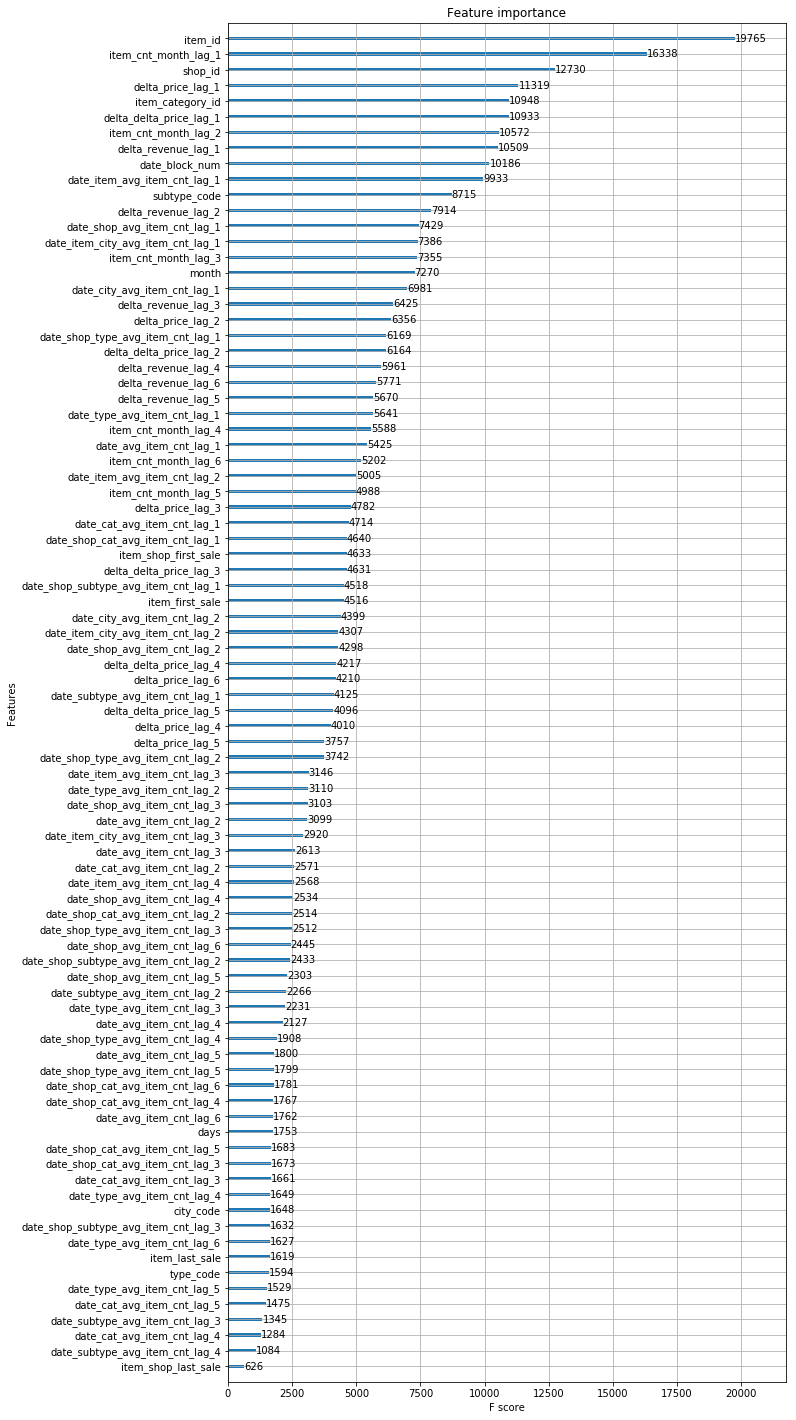

In [5]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(model, (10,25))

# Output File

In [6]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

test  = pd.read_csv('./input/test.csv').set_index('ID')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission_val-all_select_es25.csv', index=False)